# SOLA METHOD WITH NOISE
We address the task of estimating a finite‐dimensional property of an unknown model from noisy observations.  Let
$$
m \in \mathcal{M},
\quad
\tilde{\mathbf{d}} \in \mathcal{D} \cong \mathbb{R}^{N_d},
\quad
\tilde{\mathbf{p}} \in \mathcal{P} \cong \mathbb{R}^{N_p},
$$
where $\mathcal{M}$ is a separable Hilbert space, and $\mathcal{D},\mathcal{P}$ are Euclidean spaces of dimensions $N_d$ and $N_p$.


The forward map is a bounded linear operator
$$
G:\mathcal{M}\to \mathcal{D},
\qquad
[G(m)]_i = \langle K_i, m \rangle_{\mathcal{M}}
$$
and the data are modeled by
$$
\mathbf{d} = G(m) + \mathbf \eta
$$
$K_i \in \mathcal{M}$ are sensitivity kernels, and $\mathbf \eta$ is the noise. We define a gaussian measure on the data space
$$
\mu_{\mathcal D} = \mathcal N (\mathbf{\tilde d}, \mathbf C_{\mathcal D})
$$

Similarly, the property of interest is extracted via
$$
\mathcal T:\mathcal{M}\to \mathcal{P},
\qquad
[\mathcal T(m)]_k = \langle T^{(k)}, m \rangle_{\mathcal{M}}
$$
where $T^{(k)}$ are the target kernels. Our ultimate goal is to recover
$$
\bar{\mathbf{p}} = \mathcal T(\bar m),
$$
where $\bar m$ is the (unknown) true model.  Since the inverse problem is ill‐posed, we do not attempt to reconstruct $\bar m$ directly.  Instead, we seek a surrogate operator
$$
\mathbf{X}:\mathcal{D} \to \mathcal{P}
$$
that approximates the composition $\mathcal T \circ G^{-1}$ on the most probable model(s).  In practice, we will apply $\mathbf{X}$ to the MAP estimate in data space (basically, the observed data $\mathbf{\tilde{d}}$).

To ensure $\mathbf{X}$ faithfully reproduces our desired property, we enforce
$$
\mathcal T \approx \mathbf{X}\,G,
$$
and measure the discrepancy in the Hilbert–Schmidt norm. We also want $\mathbf X$ to be such that the property covariance is as small as possible.  Therefore, we seek $X$ as the solution to the following optimization problem:
$$
\min_{\mathbf{X}}\;[\|\mathcal T - \mathbf{X}G\|_{HS}^2 + Tr(\mathbf X \mathbf C_{\mathcal D} \mathbf X^*)],
\quad
\|A\|_{HS}^2 = Tr \bigl(A\,A^*\bigr).
$$

The solution is:
$$
X = \mathcal{T} G^*(GG^* + \mathbf C_{\mathcal D})^{-1}
$$

From this we can obtain the approximate the gaussian measure on the property space by pushing forward the data measure through $\mathbf X$
$$
\mu_{\mathcal P} = \mathcal N (\mathbf{\tilde p}, \mathbf C_{\mathcal P})
$$
where 
$$
    \mathbf{\tilde{p}} = X(\mathbf{\tilde{d}}),
$$
and 
$$
\mathbf C_{\mathcal P} = \mathbf X \mathbf C_{\mathcal D} \mathbf X^*
$$

In [1]:
from pygeoinf.interval.function_providers import NormalModesProvider, BumpFunctionProvider
from pygeoinf.interval.interval_domain import IntervalDomain
from pygeoinf.interval.l2_space import L2Space
from pygeoinf.hilbert_space import EuclideanSpace, LinearOperator
from pygeoinf.interval.sola_operator import SOLAOperator
from pygeoinf.interval.l2_functions import Function
from pygeoinf.linear_solvers import CholeskySolver
from pygeoinf.gaussian_measure import GaussianMeasure
import matplotlib.pyplot as plt
import numpy as np

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/random_matrix.py:6: UserWarning: A NumPy version >=1.22.4 and <2.3.0 is required for this version of SciPy (detected version 2.3.1)
  from scipy.linalg import (


We first create an domain for the functions that represent models. Using this domain, we build the model space as an L2Space. We also build the data and property spaces as euclidean spaces.

In [2]:
# Create a function domain and spaces
function_domain = IntervalDomain(0, 1)
M = L2Space(10, function_domain) # model space
N_d = 50 # number of data points
D = EuclideanSpace(N_d) # data space
N_p = 20 # number of property points
P = EuclideanSpace(N_p) # property space

Then we create a set of sensitivity kernels for the forward map, and target kernels for the property map.

In [3]:
# Create forward and property mappings
width = 0.2 # width of the bump target functions
centers = np.linspace(function_domain.a + width / 2, function_domain.b - width / 2, N_p) # centers of the bumps
# Create a normal modes provider for the forward operator
# and a bump function provider for the target operator
# Note: The random_state is set to ensure reproducibility of results
normal_modes_provider = NormalModesProvider(M, gaussian_width_percent_range=(5, 10),
                                            freq_range=(5, 10), random_state=39)
G = SOLAOperator(M, D, normal_modes_provider, integration_method='trapz', n_points=1000)
target_provider = BumpFunctionProvider(M, centers=centers, default_width=width)
T = SOLAOperator(M, P, target_provider, integration_method='trapz', n_points=1000)

/home/adrian/PhD/Inferences/pygeoinf/pygeoinf/interval/l2_functions.py:265: UserWarning: Point evaluation is not well-defined for general L² functions. Consider using a Sobolev space with s > 1/2 for point evaluation.
  warnings.warn(


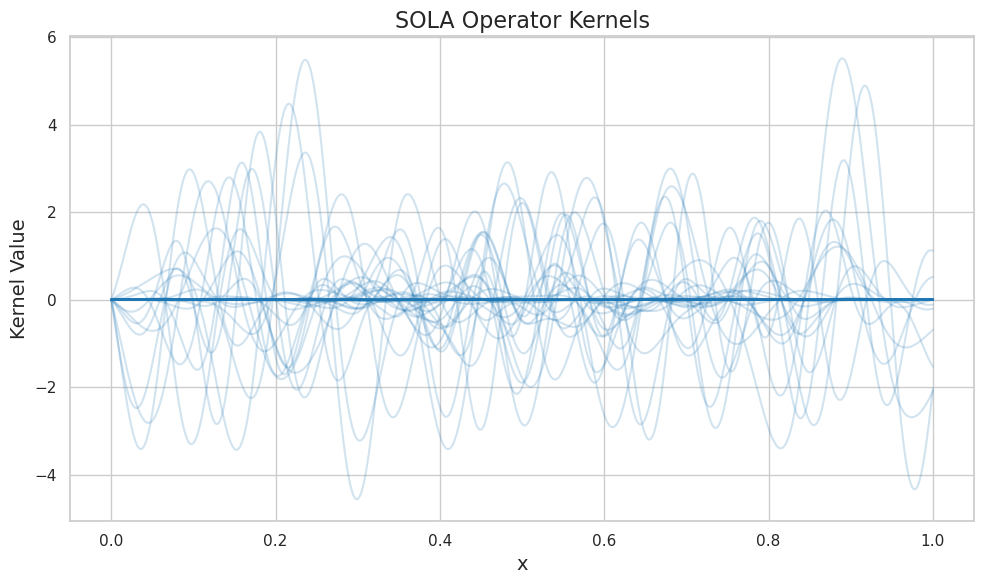

In [4]:
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
x = np.linspace(0, 1, 1000)
plt.figure(figsize=(10, 6))
for i in range(N_d):
    plt.plot(x, G.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.2)
plt.title('SOLA Operator Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

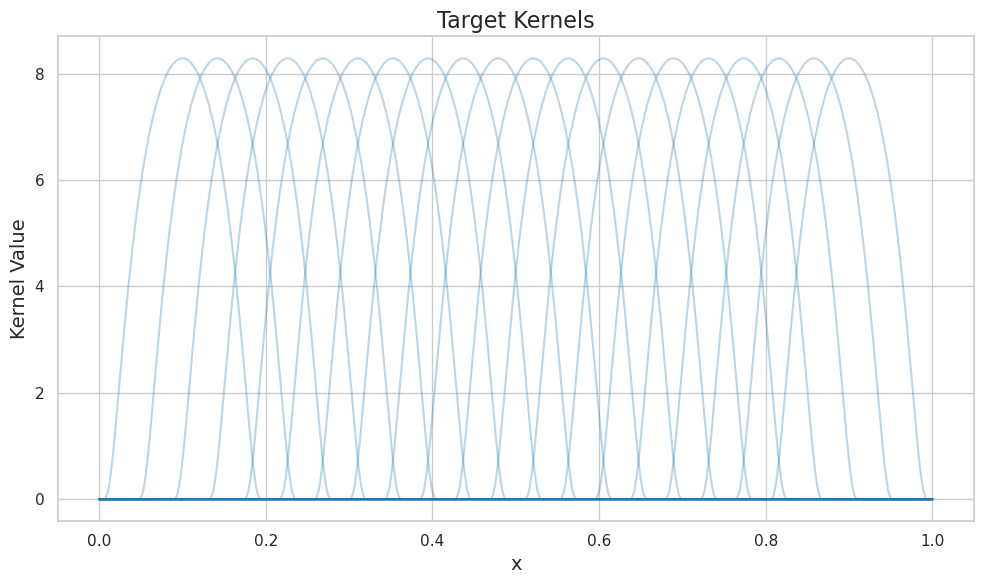

In [5]:
plt.figure(figsize=(10, 6))
for i in range(N_p):
    plt.plot(x, T.function_provider.get_function_by_index(i).evaluate(x), color='tab:blue', alpha=0.3)
plt.title('Target Kernels', fontsize=16)
plt.xlabel('x', fontsize=14)
plt.ylabel('Kernel Value', fontsize=14)
plt.tight_layout()
plt.show()

We create a true model $\bar{m}$ and the coresponding data $\mathbf{\bar{d}}$. We also create the noisy data $\mathbf{\tilde d}$

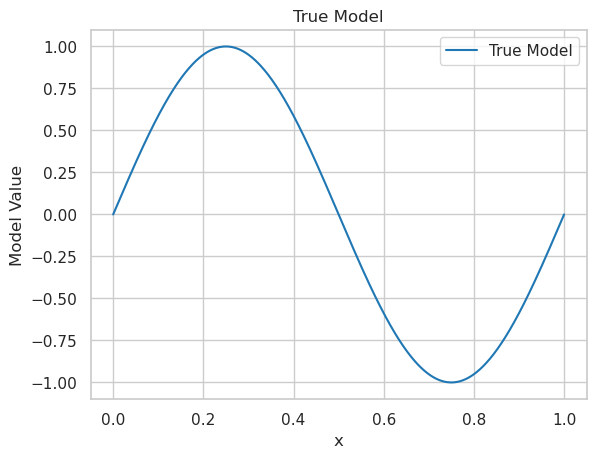

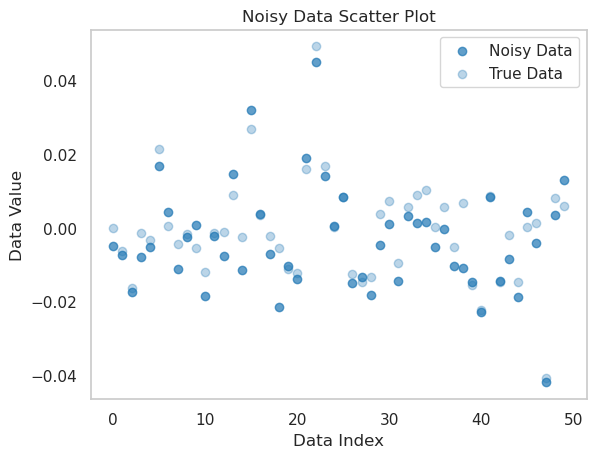

In [6]:
# Create a true model
m_bar = Function(M, evaluate_callable=lambda x: np.sin(2 * np.pi * x))
# Plot the true model
plt.plot(x, m_bar.evaluate(x), label='True Model', color='tab:blue')
plt.title('True Model')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.show()

# Create corresponding data
d_bar = G(m_bar)
# Create noisy data
d_tilde = d_bar + np.random.normal(-0.1*np.max(d_bar), 0.1*np.max(d_bar), d_bar.shape)

plt.scatter(np.arange(len(d_bar)), d_tilde, label='Noisy Data', color='tab:blue', alpha=0.7)
plt.scatter(np.arange(len(d_bar)), d_bar, label='True Data', color='tab:blue', alpha=0.3)
plt.xlabel('Data Index')
plt.ylabel('Data Value')
plt.grid()
plt.title('Noisy Data Scatter Plot')
plt.legend()
plt.show()

Now we create a covariance operator for the data measure (a simple diagonal covariance) and build the data measure. We use the noisy data as the expectation of our measure.

In [7]:
# Add Gaussian measure on data space
cov_D_matrix = np.eye(N_d) * 0.1 * np.max(d_tilde)  # covariance matrix for the noise

# Use from_covariance_matrix which automatically enables sampling
gaussian_D = GaussianMeasure.from_covariance_matrix(D, cov_D_matrix, expectation=d_tilde)

Now we compute the the solution operator $\mathbf X$ as well as the least norm pseudo-inverse.

In [8]:
# Compute normal operator and the X operator
Lambda = LinearOperator.from_matrix(D, D, G.compute_gram_matrix())
cholesky_solver = CholeskySolver(galerkin=True)
W_inv = cholesky_solver(Lambda + gaussian_D.covariance)
G_inv = G.adjoint @ W_inv
X = T @ G_inv

Altough we are not searching for a model since we are doing an inference, we can still find the model to which the mean of $\mu_{\mathcal P}$ corresponds to. That is basically the least norm solution when considering noisy data.

In [9]:
# Compute both the model solution from the true data and the noisy data
m_tilde = G_inv(d_tilde)

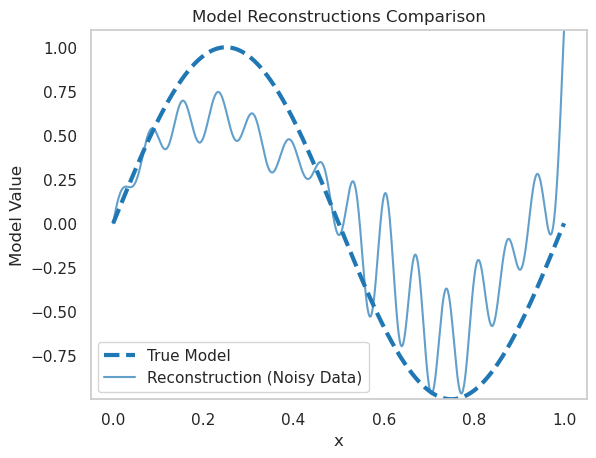

In [10]:
plt.plot(x, m_bar.evaluate(x), label='True Model', linestyle='--', color='tab:blue', linewidth=3)
plt.plot(x, m_tilde.evaluate(x), label='Reconstruction (Noisy Data)', color='tab:blue', alpha=0.7, linewidth=1.5)
plt.ylim(np.max(m_bar.evaluate(x)) * -1, np.max(m_bar.evaluate(x)) * 1.1)
plt.title('Model Reconstructions Comparison')
plt.xlabel('x')
plt.ylabel('Model Value')
plt.legend()
plt.grid()
plt.show()

Now we can obtain our solution by pushing forward the data measure through $\mathbf X$ using an affine mapping.

In [11]:
# Push forward the data measure through X to get property measure
# This automatically computes: mean = X(data_mean), covariance = X @ C_D @ X.adjoint
property_measure = gaussian_D.affine_mapping(operator=X)

p_bar = T(m_bar)  # true property

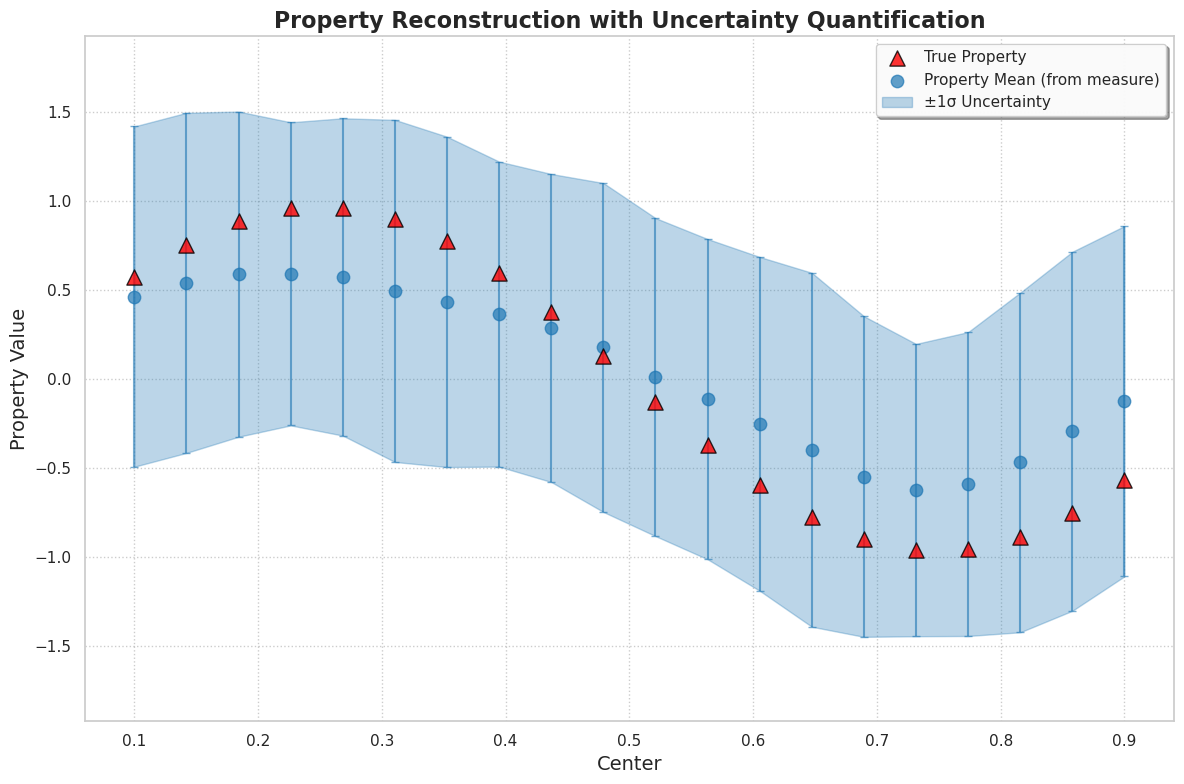

In [12]:
# Visualize property measure with uncertainty quantification
plt.figure(figsize=(12, 8))

# Get the mean from the property measure
p_mean = property_measure.expectation

# Compute standard deviations from the covariance matrix
# For each property point, get the diagonal element of the covariance
p_std = np.zeros(N_p)
for i in range(N_p):
    basis_vec = P.basis_vector(i)
    p_std[i] = np.sqrt(P.inner_product(property_measure.covariance(basis_vec), basis_vec))

# Create the main plot
plt.scatter(centers, p_bar, label='True Property', color='red', marker='^', s=120, edgecolor='black', alpha=0.8, zorder=5)
plt.scatter(centers, property_measure.expectation, label='Property Mean (from measure)', color='tab:blue', marker='o', s=80, alpha=0.7, zorder=4)

# Add uncertainty bands (mean ± 1 std)
plt.fill_between(centers, p_mean - p_std, p_mean + p_std,
                 alpha=0.3, color='tab:blue', label='±1σ Uncertainty', zorder=1)
# Add uncertainty error bars for better visibility
plt.errorbar(centers, p_mean, yerr=p_std, fmt='none', ecolor='tab:blue', alpha=0.6, capsize=3, zorder=2)

plt.ylim(np.max(p_bar) * -2, np.max(p_bar) * 2)
plt.title('Property Reconstruction with Uncertainty Quantification', fontsize=16, fontweight='bold')
plt.xlabel('Center', fontsize=14)
plt.ylabel('Property Value', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4, color='gray')
plt.legend(fontsize=11, frameon=True, loc='upper right', fancybox=True, shadow=True, framealpha=0.95)
plt.tight_layout()
plt.show()

## Resolving Kernels

The mean of the property measure can be interpreted in two distinct but ultimately equivalent ways:

1. As the **true property of the least-norm solution**,
   $$
   \mathcal{T}(\tilde{m}),
   $$
   where $\tilde{m}$ is the minimum-norm solution to the inverse problem.

2. As an **approximate mapping of the true model**,
   $$
   \mathcal{A}(\bar{m}),
   $$
   where $\bar{m}$ is the true model, and $\mathcal{A}$ approximates the true property operator $\mathcal{T}$.

We define the approximate mapping $\mathcal{A}$ as
$$
\mathcal{A} = \mathbf XG,
$$
where $G$ is the forward operator and $\mathbf X$ maps data to the property space. But why are these two interpretations equivalent?

To understand this, consider the set of all models that are consistent with the observed data $\bar{\mathbf{d}}$:
$$
S = G^{-1}(\bar{\mathbf{d}}),
$$
where $S$ is the **data preimage** under $G$. This set includes both the true model $\bar{m}$ and the least-norm solution $\tilde{m}$. Since we cannot directly access the true property $\mathcal{T}(\bar{m})$, we adopt an alternative strategy: define an approximate operator $\mathcal{A}$ that behaves like $\mathcal{T}$ **within the solution set** $S$.

The key idea is to construct $\mathcal{A}$ such that, for any model $m \in S$, the mapping $\mathcal{A}(m)$ yields the same value in the property space:
$$
\mathcal{A}(m) = \text{constant}, \quad \forall m \in S.
$$
Because $\bar{m} \in S$, this implies
$$
\mathcal{A}(\bar{m}) = \mathcal{A}(\tilde{m}) = \mathcal{T}(\tilde{m}).
$$
Thus, although we cannot compute $\mathcal{T}(\bar{m})$ directly, we have nonetheless recovered a meaningful approximation of it through $\mathcal{A}(\bar{m})$.

This motivates defining $\mathcal{A}$ as the composition:
$$
\mathcal{A} = \mathbf XG,
$$
because $G(m) = \bar{\mathbf{d}}$ for all $m \in S$, and $\mathbf X$ then maps $\bar{\mathbf{d}}$ to the property space. The resulting operator $\mathcal{A}$ is not the exact property of the true model, but under this philosophy, it is still informative—it tells us something consistent about the true model based on the data.

Importantly, this reinterpretation leads to the same optimization problem used to determine $\mathbf X$. The difference lies only in the **interpretation** of the result: instead of viewing the output as $\mathcal{T}(\tilde{m})$, we now interpret it as an approximation $\mathcal{A}(\bar{m})$ of $\mathcal{T}(\bar{m})$.

Just as the operator $\mathcal{T}$ is characterized by **target kernels**, the approximate operator $\mathcal{A}$ is associated with its own **resolving kernels**, defined as:
$$
A^{(k)} = \sum_i [\mathbf X]_{ki} K_i,
$$
where $\{K_i\}$ are basis functions in the model space. These resolving kernels describe how the data constrain the recovery of each property component.


In [13]:
# Imposing unimodularity
M_one = Function(M, evaluate_callable=lambda x: np.ones_like(x))
v = G(M_one)
w = np.ones(N_p)
u = W_inv(v)
beta = D.inner_product(v, u)
correction = LinearOperator.from_matrix(D, P, np.outer((X(v) - w) / beta, u))
X_unimodular = X - correction
property_measure_unimodular = gaussian_D.affine_mapping(operator=X_unimodular)

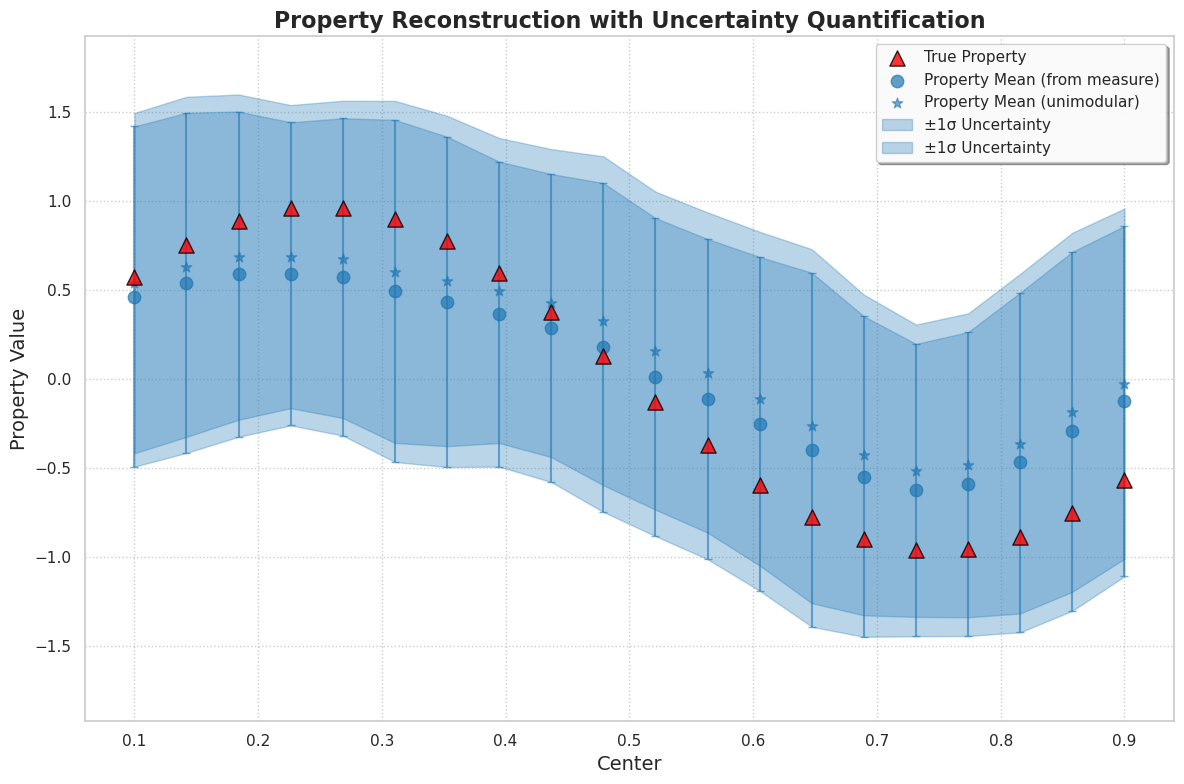

In [15]:
# Visualize property measure with uncertainty quantification
plt.figure(figsize=(12, 8))

# Get the mean from the property measure
p_mean = property_measure.expectation

# Compute standard deviations from the covariance matrix
# For each property point, get the diagonal element of the covariance
p_std = np.zeros(N_p)
for i in range(N_p):
    basis_vec = P.basis_vector(i)
    p_std[i] = np.sqrt(P.inner_product(property_measure.covariance(basis_vec), basis_vec))

# Create the main plot
plt.scatter(centers, p_bar, label='True Property', color='red', marker='^', s=120, edgecolor='black', alpha=0.8, zorder=5)
plt.scatter(centers, p_mean, label='Property Mean (from measure)', color='tab:blue', marker='o', s=80, alpha=0.7, zorder=4)
plt.scatter(centers, property_measure_unimodular.expectation, label='Property Mean (unimodular)', color='tab:blue', marker='*', s=60, alpha=0.6, zorder=3)

# Add uncertainty bands (mean ± 1 std)
plt.fill_between(centers, p_mean - p_std, p_mean + p_std,
                 alpha=0.3, color='tab:blue', label='±1σ Uncertainty', zorder=1)
plt.fill_between(centers, property_measure_unimodular.expectation - p_std, property_measure_unimodular.expectation + p_std,
                 alpha=0.3, color='tab:blue', label='±1σ Uncertainty', zorder=1)

# Add uncertainty error bars for better visibility
plt.errorbar(centers, p_mean, yerr=p_std, fmt='none', ecolor='tab:blue', alpha=0.6, capsize=3, zorder=2)

plt.ylim(np.max(p_bar) * -2, np.max(p_bar) * 2)
plt.title('Property Reconstruction with Uncertainty Quantification', fontsize=16, fontweight='bold')
plt.xlabel('Center', fontsize=14)
plt.ylabel('Property Value', fontsize=14)
plt.grid(True, linestyle=':', alpha=0.4, color='gray')
plt.legend(fontsize=11, frameon=True, loc='upper right', fancybox=True, shadow=True, framealpha=0.95)
plt.tight_layout()
plt.show()